Прогноз динамики цен на нефть марки Brent


In [ ]:
#  https://investfunds.ru/indexes/624/ c 01-01-2014 по 05-12-2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
from __future__ import annotations
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tsa.stattools import adfuller, pacf,acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.linear_model import LinearRegression

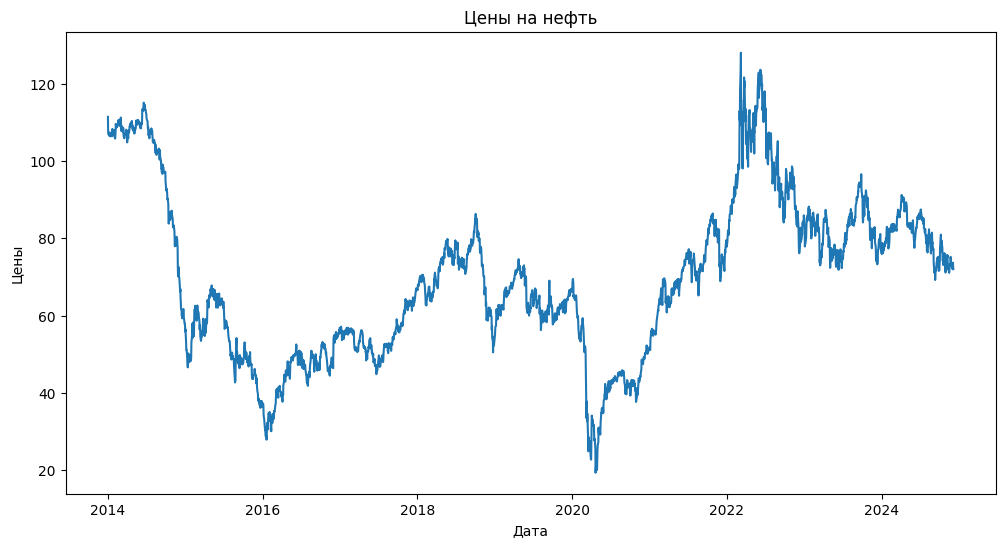

ADF статистика: -1.5519998863489954
p-значение: 0.507649074460851
Ряд нестационарен.


In [203]:
def analyze_timeseries(file_path):

  df = pd.read_excel(file_path)
  df_idx = df.set_index('Дата')

  if df['Значение'].isnull().any():
    print("В данных присутствуют пропущенные значения")

  plt.figure(figsize=(12, 6))
  plt.plot(df_idx.index, df_idx['Значение'])
  plt.title('Цены на нефть')
  plt.xlabel('Дата')
  plt.ylabel('Цены')
  plt.show()

# Тест на стационарность (тест Дики-Фуллера)
  result = adfuller(df_idx['Значение'])

  print('ADF статистика:', result[0])
  print('p-значение:', result[1])

  if result[1] <= 0.05:
    print("Ряд стационарен.")
  else:
    print("Ряд нестационарен.")

  return df, df_idx


# file_path = 'C:\\Users\\Asus\\Downloads\\brent.xlsx'
file_path = '/content/drive/MyDrive/sber/brent.xlsx'
df, df_idx = analyze_timeseries(file_path)


In [204]:
# сортировка по возрастанию
df_idx = df_idx.sort_index()

# Анализ временного ряда

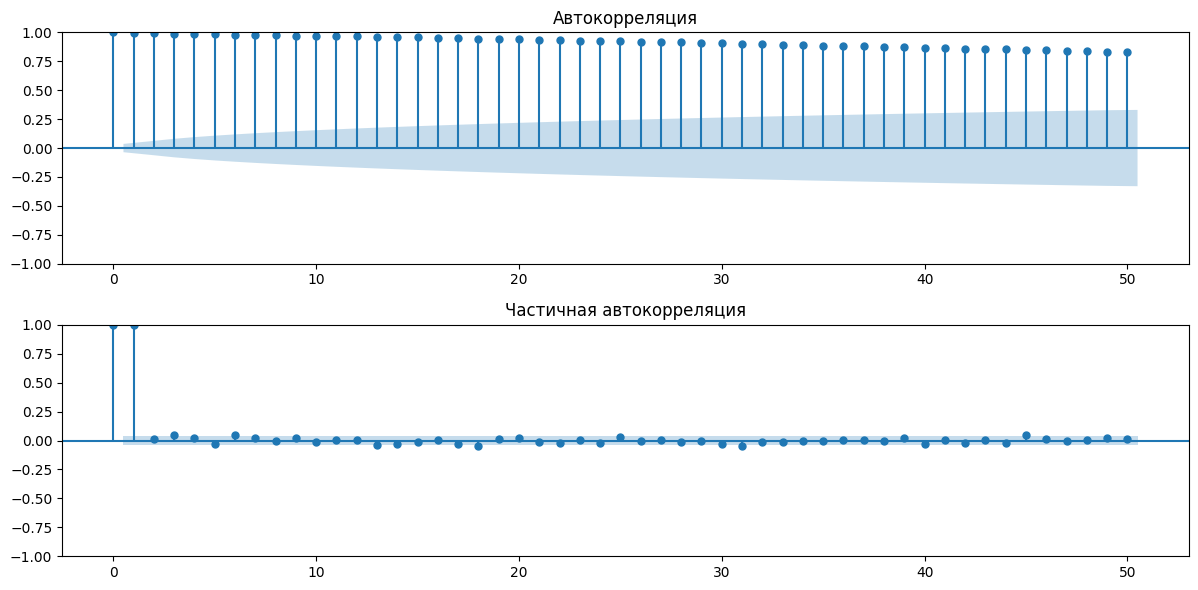

In [ ]:
# автокорреляция
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df_idx['Значение'], lags=50, ax=plt.gca())
plt.title('Автокорреляция')

plt.subplot(212)
plot_pacf(df_idx['Значение'], lags=50, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

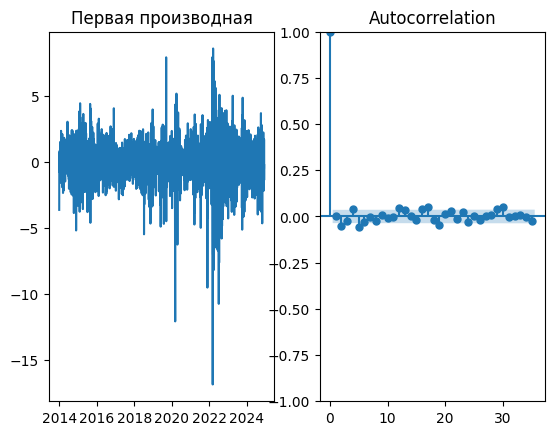

In [ ]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("Первая производная")
ax1.plot(df_idx['Значение'].diff())

ax2 = f.add_subplot(122)
plot_acf(df_idx['Значение'].diff().dropna(), ax=ax2)
plt.show()

Скользящее среднее

In [194]:
# создадим признак скользящего среднего
df_idx['rolling_mean'] = df_idx.rolling(24).mean().shift(1)

In [195]:
# создадим признак скользящего стандартного отклонения
df_idx['rolling_std'] = df_idx[['Значение']].rolling(24).std()

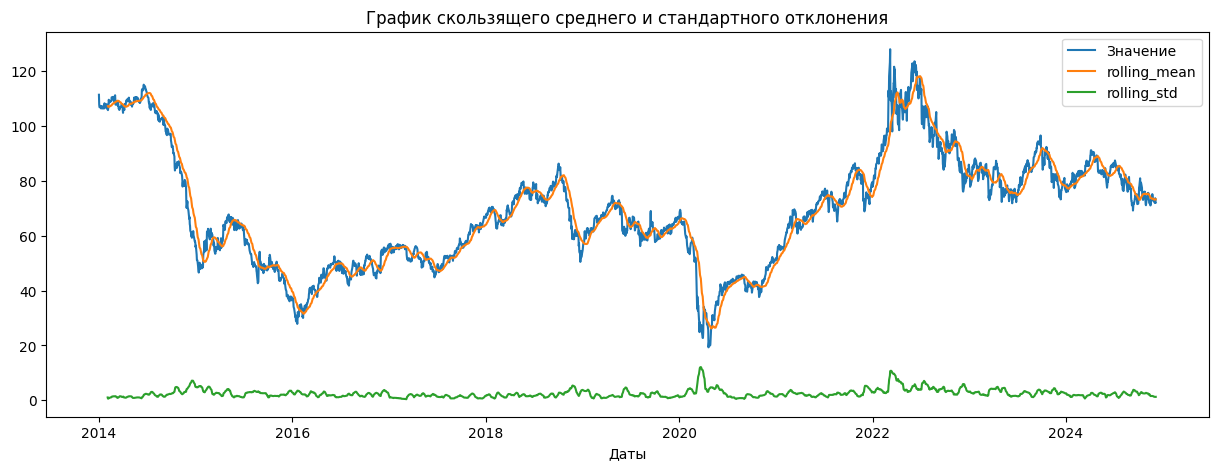

In [166]:
plt.figure(figsize=(15,5))
plt.plot(df_idx)
plt.title('График скользящего среднего и стандартного отклонения')
plt.legend(list(df_idx.columns))
plt.xlabel('Даты')
# plt.ylabel()
plt.show()

In [169]:
from plotly.subplots import make_subplots

In [172]:
fig = make_subplots(rows=2, cols=1, subplot_titles=("График цен",
                                                    'График скользящего среднего и стандартного отклонения'))

fig.add_trace(go.Scatter(y=df_idx['Значение'], x=df_idx.index, name='Значение'), 1,1)
fig.add_trace(go.Scatter(y=df_idx['rolling_mean'], x=df_idx.index, name='rolling_mean'), 2, 1)
fig.add_trace(go.Scatter(y=df_idx['rolling_std'], x=df_idx.index, name='rolling_std',
                        marker=dict(color='yellow')
                        ), 2,1)

fig.update_layout(legend_orientation='h',
                 legend=dict(x=.5, xanchor='center'),
                 margin = dict(l=0, r=0, t=25, b=0))
fig.update_layout(title="График в Plotly")
fig.update_xaxes(title='Даты', col=1, row=1)
fig.update_xaxes(title='Даты', col=1, row=2)
fig.update_yaxes(title='Цена', col=1, row=1)
fig.update_yaxes(title='Цена', col=1, row=2)
fig.show()


Тренд и сезонность

In [173]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [220]:
df_idx = df_idx.asfreq('B')
df_idx = df_idx.fillna(method='ffill')

In [221]:
decomposed = seasonal_decompose(df_idx['Значение'], model='additive')

In [222]:
fig = make_subplots(rows=4, cols=1, subplot_titles=('График тренда',
                                                    'График cезонности',
                                                    'График cезонности в рамках недели',
                                                    'График шума'))

fig.add_trace(go.Scatter(y=decomposed.trend.rolling(24*7).mean(), x=df_idx.index, name='Значение'), 1,1)
fig.add_trace(go.Scatter(y=decomposed.seasonal, x=df_idx.index, name='rolling_mean'), 2, 1)
fig.add_trace(go.Scatter(y=decomposed.seasonal[:(24*7)], x=df_idx.index, name='rolling_mean'), 3, 1)
fig.add_trace(go.Scatter(y=decomposed.resid, x=df_idx.index, name='rolling_std',
                        marker=dict(color='green')
                        ), 4,1)
fig.update_layout(legend_orientation='h',
                 legend=dict(x=.5, xanchor='center'),
                 margin = dict(l=0, r=0, t=25, b=0))
fig.update_layout(title="График в Plotly")

fig.update_xaxes(title='Даты', col=1, row=4)
fig.update_yaxes(title='Количество', col=1, row=1)
fig.update_yaxes(title='Количество', col=1, row=2)
fig.update_yaxes(title='Количество', col=1, row=3)
fig.update_yaxes(title='Количество', col=1, row=4)
fig.show()

# ARIMA/SARIMA

In [ ]:
# поиск параметров для модели вручную
# ищем наибольший вклад компоненты в корреляцию по первым двум производным
data_ = df_idx['Значение']
pacf_coeff = np.zeros(22)
max_lag = 22

for p in range(1, 3):
    data_ = data_.diff().dropna()
    pacf_values = np.abs(pacf(data_, nlags = max_lag - 1))
    pacf_coeff[:len(pacf_values)] += pacf_values

pacf_coeff = list(pacf_coeff)
p_best = pacf_coeff.index(max(pacf_coeff))+1
print ("Порядок авторегрессии (AR) равен", p_best)

Порядок авторегрессии (AR) равен 1


In [ ]:
data_ = df_idx['Значение']
d_best = 0
for d in range(1, 5):
    data_ = data_.diff().dropna()
    result = adfuller(data_)
    print ("p-значение для " + str(d) + "-производной ряда", result[1])
    if d_best == 0 and result[1] < 0.05:
        d_best = d
print ("d – порядок интегрирования (I) равен", d_best)

p-значение для 1-производной ряда 4.822278074209066e-22
p-значение для 2-производной ряда 2.661264052388544e-30
p-значение для 3-производной ряда 0.0
p-значение для 4-производной ряда 0.0
d – порядок интегрирования (I) равен 1


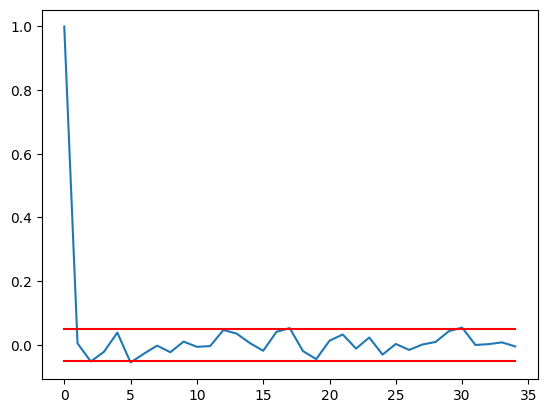

q – порядок скользящего среднего (MA) равен 1


In [ ]:
# ищем порядок скользящего среднего (по вкладу компонентов первой производной)
q_best = 0
result = acf(df_idx['Значение'].diff().dropna())
plt.plot(result)
plt.plot([0.05]*len(result), color="red")
plt.plot([-0.05]*len(result), color="red")
plt.show()
for i in range(len(result)):
    if abs(result[i]) > 0.05:
        q_best = i + 1
    else:
        break
print ("q – порядок скользящего среднего (MA) равен", q_best)

In [ ]:
model = ARIMA(df_idx['Значение'], order=(p_best, d_best, q_best)).fit()
print (model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Значение   No. Observations:                 2971
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5456.921
Date:                Wed, 12 Mar 2025   AIC                          10919.843
Time:                        13:31:26   BIC                          10937.832
Sample:                             0   HQIC                         10926.317
                               - 2971                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7661      0.126      6.057      0.000       0.518       1.014
ma.L1         -0.7914      0.120     -6.587      0.000      -1.027      -0.556
sigma2         2.3090      0.026     89.123      0.0

In [ ]:
# Поиск оптимальных коэффициентов ARIMA

aic_best = float('inf')  # Инициализируем с бесконечностью
coeff_best = (0, 0, 0) # Начнём с (0,0,0), чтобы было от чего отталкиваться
max_p_q = 3  # Ограничиваем p и q для избежания ошибок
# Создаем ряд после дифференцирования, если это требуется:
if d_best > 0:
  data_diff = df_idx['Значение'].diff().dropna()
else:
  data_diff = df_idx['Значение']
for p in range(1, max_p_q + 1):
    for q in range(1, max_p_q+1):

        try:
            model_ = ARIMA(data_diff, order=(p, 0, q)).fit() # d=0 так как уже применили diff.
            aic = model_.aic
            if aic < aic_best:
                coeff_best = (p, d_best, q)
                aic_best = aic
        except Exception as e:
             print(f"Ошибка при обучении ARIMA с параметрами (p={p}, q={q}): {e}")



print ("Наилучшие коффициенты:", coeff_best)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Наилучшие коффициенты: (3, 1, 3)


In [ ]:
model = ARIMA(df_idx['Значение'][:-10], order=coeff_best).fit()
forecast = model.get_forecast(steps=10).predicted_mean

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


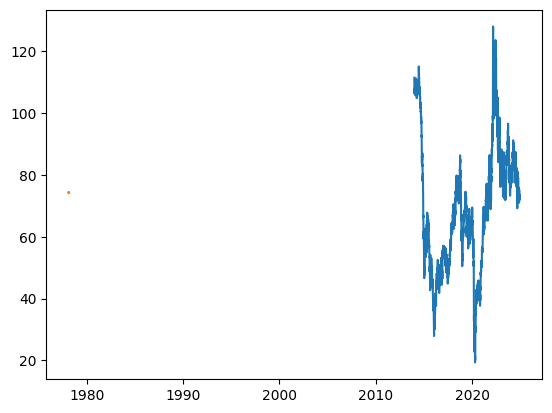

In [ ]:
plt.plot(df_idx['Значение'])
plt.plot(forecast)
plt.show()

In [ ]:
# !pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.1 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=9103.928, Time=5.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9107.802, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9106.100, Time=2.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9105.846, Time=2.80 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9105.914, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=9103.850, Time=0.86 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=9104.827, Time=2.21 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=9104.104, Time=0.85 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=9103.586, Time=12.16 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=20.85 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=9103.562, Time=12.08 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=9104.773, Time=2.22 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=9105.560, Time=14.41 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=9105.560, Time=16.29 sec
 ARIMA(1,1,1)(2,0,1

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


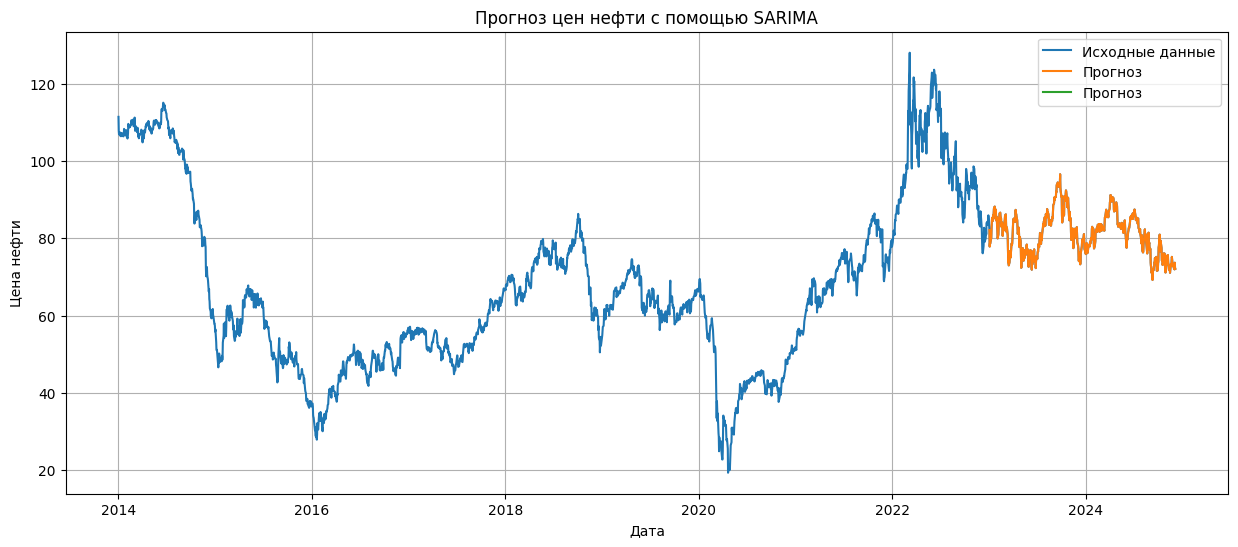

In [ ]:
brent_df_series = df_idx['Значение']
brent_y_hist = brent_df_series.loc['2014':'2022']
brent_y_future = brent_df_series.loc['2023':]


# Оптимизация параметров SARIMA
try:
    model_auto_arima = pm.auto_arima(brent_y_hist,
                                     start_p=0, start_q=0,
                                     max_p=5, max_q=5, m=12,
                                     d=None, seasonal=True,
                                     trace=True,
                                     error_action='ignore',
                                     suppress_warnings=True,
                                     stepwise=True)
    order = model_auto_arima.order
    seasonal_order = model_auto_arima.seasonal_order
    print(f"Optimal order: {order}, Seasonal order: {seasonal_order}")
except Exception as e:
    order = (1, 1, 1)
    seasonal_order = (0, 0, 1, 12)

model = SARIMAX(brent_y_hist, order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)


future_dates = pd.date_range(start=df_idx.index[-1] + pd.Timedelta(days=1), end='2025-12-31', freq='D')
forecast = results.get_prediction(start=len(brent_y_hist), end=len(brent_y_hist) + len(future_dates) - 1)


forecast_df = pd.DataFrame({'Предсказания': forecast.predicted_mean}, index=future_dates)
brent_y_forecast_sarima_all = pd.concat([brent_df_series, forecast_df])

plt.figure(figsize=(15, 6))
plt.plot(brent_df_series, label='Исходные данные')
plt.plot(brent_y_forecast_sarima_all['2023':], label='Прогноз')
plt.xlabel('Дата')
plt.ylabel('Цена нефти')
plt.title('Прогноз цен нефти с помощью SARIMA')
plt.legend()
plt.grid(True)
plt.show()

# Генерация признаков и разбивка данных

In [56]:
def make_features(data_0, rolling_mean_size, max_lag, lag=False, diff=False, cat_num_features=False):

    data = data_0.copy()
    CAT_FEATURES = ['day', 'month', 'weekday']
    NUM_FEATURES = []
    # создадим признак скользящего среднего
    target = 'target'
    if rolling_mean_size > 0:
        data['rolling_mean'] = data[[target]].rolling(rolling_mean_size).mean().shift(1)
        NUM_FEATURES.append('rolling_mean')

    # генерим фичи по времени
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['weekday'] = data.index.weekday

    # генерим фичи lag, diff
    if lag==True and diff==True:
        for n in range(1, max_lag+1):
            data[f'lag_{n}'] = data[target].shift(n)
            data[f'diff_{n}'] = data[target].shift(n-1) - data[target].shift(n)
            NUM_FEATURES.append(f'lag_{n}')
            NUM_FEATURES.append(f'diff_{n}')

    elif lag==True:
        for n in range(1, max_lag+1):
            data[f'lag_{n}'] = data[target].shift(n)
            NUM_FEATURES.append(f'lag_{n}')

    elif diff==True:
        for n in range(1, max_lag+1):
            data[f'diff_{n}'] = data[target] - data[target].shift(n)
            NUM_FEATURES.append(f'diff_{n}')

    # удаляем строки содержащие Nan
    data.dropna(inplace=True)

    # обновим target после удаления строк с Nan
    target = data['target']
    # удалим в X_train поле ['target']
    data = data.drop('target', axis=1)

    if cat_num_features == True:
        return data, target, CAT_FEATURES, NUM_FEATURES
    else:
        return data, target

In [57]:
def train_valid_test(data):
    X_train, X_test, y_train, y_test = train_test_split(data, data['target'], test_size=0.2, shuffle=False)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [58]:
df_idx['target'] = df_idx['Значение']
df_idx.head(3)

,Значение,target
Дата,,
2014-01-01,111.39,111.39
2014-01-02,107.78,107.78
2014-01-03,106.89,106.89


In [59]:
import plotly.graph_objects as go

In [60]:
def plotly_esy_graph(pred, test, date):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=test, x = date, name='fact'))
    fig.add_trace(go.Scatter(y=pred, x = date, name='pred'))
    fig.update_layout(legend_orientation='h',
                     legend=dict(x=.5, xanchor='center'),
                     title='График сравнения fact pred',
                     yaxis_title= 'Количество вызовов',
                     margin = dict(l=0, r=0, t=25, b=0))
    fig.show()
    return

In [61]:
X_train_0, X_valid_0, X_test_0, y_train_0, y_valid_0, y_test_0 = train_valid_test(df_idx[['target']])

In [62]:
X_train_0.shape, X_valid_0.shape, X_test_0.shape, y_train_0.shape, y_valid_0.shape, y_test_0.shape

((2376, 1), (297, 1), (298, 1), (2376,), (297,), (298,))

In [ ]:
# генерация фич для X_train
X_train, y_train = make_features(X_train_0,
                                 rolling_mean_size = 0,
                                 max_lag = 1,
                                 lag=True,
                                 diff=False,
                                 cat_num_features=False)

In [ ]:
# генерация фич для X_valid
X_valid, y_valid = make_features(X_valid_0,
                                 rolling_mean_size = 0,
                                 max_lag = 1,
                                 lag=True,
                                 diff=False,
                                 cat_num_features=False
                                )

In [ ]:
X_train.head(2)

,day,month,weekday,lag_1
Дата,,,,
2014-01-02,2,1,3,111.39
2014-01-03,3,1,4,107.78


# Модель линейной регрессии

Исключены признаки скользящего среднего и дифференциальный признак. Используем только признаки принадлежности по времени и один лаг.

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
# прогноз pred_y_train
pred_y_train = model_lr.predict(X_train)

In [ ]:
# прогноз pred_y_valid
pred_y_valid = model_lr.predict(X_valid)

In [ ]:
rmse_pred_y_train = mean_squared_error(pred_y_train, y_train)**0.5
print('rmse_pred_y_train', rmse_pred_y_train)

rmse_pred_y_train 1.4904801524643159


In [ ]:
rmse_pred_y_valid = mean_squared_error(pred_y_valid, y_valid)**0.5
print('rmse_pred_y_valid', rmse_pred_y_valid)

rmse_pred_y_valid 1.8077812215122697


In [ ]:
date_train = X_train.index
plotly_esy_graph(pred_y_train,y_train, date_train)

In [ ]:
date_valid = X_valid.index
plotly_esy_graph(pred_y_valid,y_valid, date_valid)

Добавим дифференциальный признак (таргет минус лаг)

In [ ]:
# генерация фич для X_train
X_train, y_train = make_features(X_train_0,
                                 rolling_mean_size = 0,
                                 max_lag = 1,
                                 lag=True,
                                 diff=True,
                                 cat_num_features=False)

In [ ]:
# генерация фич для X_valid
X_valid, y_valid = make_features(X_valid_0,
                                 rolling_mean_size = 0,
                                 max_lag = 1,
                                 lag=True,
                                 diff=True,
                                 cat_num_features=False
                                )

In [ ]:
# X_train
X_train.head(2)

,day,month,weekday,lag_1,diff_1
Дата,,,,,
2014-01-02,2,1,3,111.39,-3.61
2014-01-03,3,1,4,107.78,-0.89


In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

pred_y_train = model_lr.predict(X_train)
pred_y_valid = model_lr.predict(X_valid)

rmse_pred_y_train = mean_squared_error(pred_y_train, y_train)**0.5
print('rmse_pred_y_train', rmse_pred_y_train)
rmse_pred_y_valid = mean_squared_error(pred_y_valid, y_valid)**0.5
print('rmse_pred_y_valid', rmse_pred_y_valid)

date_train = X_train.index
plotly_esy_graph(pred_y_train,y_train, date_train)

date_valid = X_valid.index
plotly_esy_graph(pred_y_valid,y_valid, date_valid)

rmse_pred_y_train 1.6568071966394455e-14
rmse_pred_y_valid 1.5208073158187998e-14


Используем только зависимые от времени признаки

In [ ]:
# генерация фич для X_train
X_train_empty, y_train_empty = make_features(X_train_0,
                                 rolling_mean_size = 0,
                                 max_lag = 1,
                                 lag=False,
                                 diff=False,
                                 cat_num_features=False)

In [ ]:
# генерация фич для X_valid
X_valid_empty, y_valid_empty = make_features(X_valid_0,
                                 rolling_mean_size = 0,
                                 max_lag = 1,
                                 lag=False,
                                 diff=False,
                                 cat_num_features=False
                                )

In [ ]:
model_lr_empty = LinearRegression()
model_lr_empty.fit(X_train_empty, y_train_empty)

LinearRegression()

In [ ]:
pred_y_train_empty = model_lr_empty.predict(X_train_empty)
pred_y_valid_empty = model_lr_empty.predict(X_valid_empty)

In [ ]:
rmse_pred_y_train_empty = mean_squared_error(pred_y_train_empty, y_train_empty)**0.5
print('rmse_pred_y_train_empty', rmse_pred_y_train_empty)

rmse_pred_y_train_empty 20.915672564089625


In [ ]:
date_valid = X_train_empty.index

plotly_esy_graph(pred_y_train_empty, y_train_empty, date_valid)

In [ ]:
rmse_pred_y_valid_empty = mean_squared_error(pred_y_valid_empty, np.array(y_valid_empty)) ** 0.5
print('rmse_pred_y_valid_empty', rmse_pred_y_valid_empty)

rmse_pred_y_valid_empty 20.62632696532243


In [ ]:
date_valid = X_valid_empty.index
plotly_esy_graph(pred_y_valid_empty,y_valid_empty, date_valid)

In [ ]:
# посчитаем RMSE при прогнозе взята средняя величина y_train.mean()
# проверка модели на адекватность
rmse_pred_y_valid_empty = mean_squared_error(\
    np.array([y_train.mean() for x in range(y_valid_empty.shape[0])]), np.array(y_valid_empty))**0.5
print('rmse при среднем прогнозе', rmse_pred_y_valid_empty)

rmse при среднем прогнозе 20.041241973098273


Используем признак скользящего среднего, с глубиной 24, а также 24 признака лага. Дифференцированные признаки не используем

In [ ]:
df_idx['target'] = df_idx['Значение']

In [ ]:
# генерация фич
X_data, y_data = make_features(df_idx[['target']],
                                 rolling_mean_size = 24,
                                 max_lag = 24,
                                 lag=True,
                                 diff=False,
                                 cat_num_features=False)

In [66]:
def train_valid_test_correct(X_data, y_data):

    '''Метод для разбивки на train_valid_test для X_data, y_data'''
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_correct(X_data, y_data)

In [ ]:
model_lr_correct = LinearRegression()
model_lr_correct.fit(X_train, y_train)

LinearRegression()

In [ ]:
pred_y_train = model_lr_correct.predict(X_train)
pred_y_valid = model_lr_correct.predict(X_valid)

In [ ]:
rmse_pred_y_train = mean_squared_error(pred_y_train, y_train)**0.5
print('rmse_pred_y_train', rmse_pred_y_train)

rmse_pred_y_train 1.480646919606572


In [ ]:
rmse_pred_y_valid = mean_squared_error(pred_y_valid, y_valid)**0.5
print('rmse_pred_y_valid', rmse_pred_y_valid)

rmse_pred_y_valid 1.7874701733827822


In [ ]:
date_valid = X_valid.index
plotly_esy_graph(pred_y_valid, y_valid, date_valid)

Оценим наилучшую модель на валидационной выборке

In [80]:
from sklearn.model_selection import TimeSeriesSplit

In [81]:
from sklearn.model_selection import cross_val_score

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
scores = cross_val_score(LinearRegression(),
                         pd.concat((X_train, X_valid), axis=0),
                         pd.concat((y_train, y_valid), axis=0),
                         cv = tscv,
                         scoring = 'neg_mean_squared_error')

In [ ]:
scores

array([-1.21849802, -0.90850977, -2.3491136 , -1.67117166, -6.72006669])

In [ ]:
# Итоговый результат RMSE по кросс-валидации с помощью TimeSeriesSplit
cv_RMSE_lr = (scores.mean()*(-1))**0.5
print('cv_RMSE_lr', cv_RMSE_lr)

cv_RMSE_lr 1.6042044592862477


# Модель NeuralProphet

In [126]:
df_idx['ds'] = df_idx.index
df_idx['y'] = df_idx['Значение']
data_row = df_idx[['ds', 'y']].reset_index().drop('Дата', axis=1)

In [127]:
data_row

,ds,y
0,2014-01-01,111.39
1,2014-01-02,107.78
2,2014-01-03,106.89
3,2014-01-06,106.73
4,2014-01-07,107.35
...,...,...
2966,2024-11-29,72.38
2967,2024-12-02,71.93
2968,2024-12-03,73.66
2969,2024-12-04,72.31


In [ ]:
# !pip install neuralprophet

In [128]:
test_length = 365
df_train = data_row.iloc[:-test_length]
df_test = data_row.iloc[-test_length:]

In [ ]:
from neuralprophet import NeuralProphet

In [ ]:
nprophet_model = NeuralProphet()
metrics = nprophet_model.fit(df_train, freq="D")
future_df = nprophet_model.make_future_dataframe(df_train,
                                                 periods = test_length,
                                                 n_historic_predictions=len(df_train))
preds_df_2 = nprophet_model.predict(future_df)

In [141]:
nprophet_model.plot(preds_df_2)

WARNING - (NP.plotting.log_warning_resampler_switch_to_valid_env) - Warning: plotly-resampler not supported for the environment you are using. Plotting backend automatically switched to 'plotly' without resampling 


In [142]:
nprophet_model.plot_components(preds_df_2)

WARNING - (NP.plotting.log_warning_resampler_switch_to_valid_env) - Warning: plotly-resampler not supported for the environment you are using. Plotting backend automatically switched to 'plotly' without resampling 


In [136]:
print(f"NeuralProphet:\t{(mean_squared_error(df_test['y'], preds_df_2.iloc[-test_length:]['yhat1']))**0.5:.4f}")

NeuralProphet:	27.5257


#Модель Градиентного бустинга

In [63]:
# генерация фич
X_data_gb, y_data_gb, CAT_FEATURES, NUM_FEATURES = \
     make_features(df_idx[['target']],
     rolling_mean_size = 24,
     max_lag = 24,
     lag=True,
     diff=False,
     cat_num_features=True)

In [64]:
X_data_gb.head(2)

,rolling_mean,day,month,weekday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Дата,,,,,,,,,,,,,,,,,,,,,
2014-02-04,107.246667,4,2,1,106.04,106.40,107.95,107.85,107.41,106.69,...,106.39,106.75,107.25,106.39,107.15,107.35,106.73,106.89,107.78,111.39
2014-02-05,107.012917,5,2,2,105.78,106.04,106.40,107.95,107.85,107.41,...,107.13,106.39,106.75,107.25,106.39,107.15,107.35,106.73,106.89,107.78


In [67]:
X_train_gb, X_valid_gb, X_test_gb, y_train_gb, y_valid_gb, y_test_gb = train_valid_test_correct(X_data_gb, y_data_gb)

In [ ]:
# !pip install catboost

In [70]:
from catboost import CatBoostRegressor

In [ ]:
cbr = CatBoostRegressor(cat_features=CAT_FEATURES)
cbr.fit(X_train_gb, y_train_gb)

In [72]:
pred = cbr.predict(X_test_gb)

In [76]:
print('RMSE', \
      round(mean_squared_error(pred, y_test_gb) ** 0.5, 2))

RMSE 2.42


In [77]:
# Построим график сравнения pred fact
date_valid = X_valid_gb.index
plotly_esy_graph(pred, y_test_gb, date_valid)

In [78]:
from sklearn.model_selection import GridSearchCV

In [115]:
# поиск лучших гиперпараметров через GridSearchCV
parameters =[{
    "n_estimators": [100, 250, 500, 800],
    'depth': [5, 7, 10]
}]

tscv = TimeSeriesSplit(8)
model_GSCV = GridSearchCV(
        estimator = CatBoostRegressor(
                    loss_function='RMSE',
                    verbose=False,
                    cat_features=CAT_FEATURES),
        param_grid = parameters,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        cv=tscv,
        verbose=1
)

In [116]:
model_GSCV.fit(X_train_gb, y_train_gb)

Fitting 8 folds for each of 12 candidates, totalling 96 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7e90ccda5f50>,
             n_jobs=-1,
             param_grid=[{'depth': [5, 7, 10],
                          'n_estimators': [100, 250, 500, 800]}],
             scoring='neg_root_mean_squared_error', verbose=1)

In [117]:
# смотрим наилучшие параметры
model_GSCV.best_params_

{'depth': 7, 'n_estimators': 500}

In [118]:
# таблица результатов
df_results_gs = pd.DataFrame(model_GSCV.cv_results_)
df_results_gs

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,1.530080,0.404163,0.010075,0.002327,5,100,"{'depth': 5, 'n_estimators': 100}",-12.592480,-4.704382,-1.299379,-10.502138,-1.874271,-3.805856,-1.631528,-8.062869,-5.559113,4.048523,12
1,3.238558,0.719406,0.006954,0.002309,5,250,"{'depth': 5, 'n_estimators': 250}",-9.793236,-4.205549,-1.455278,-6.806730,-1.730245,-4.075023,-1.590907,-7.656676,-4.664206,2.931728,8
2,6.472227,0.861996,0.007343,0.002206,5,500,"{'depth': 5, 'n_estimators': 500}",-9.349992,-3.648989,-1.344194,-7.689994,-1.684496,-4.178498,-1.526686,-7.263634,-4.585810,2.933249,6
3,10.668553,0.781034,0.008100,0.003209,5,800,"{'depth': 5, 'n_estimators': 800}",-9.358650,-3.228192,-1.367259,-7.057855,-1.692093,-4.051987,-1.480284,-7.274208,-4.438816,2.882072,3
4,3.026719,0.654582,0.008939,0.003212,7,100,"{'depth': 7, 'n_estimators': 100}",-9.147091,-4.755729,-1.439236,-8.584091,-1.925446,-5.052524,-1.636701,-7.965384,-5.063275,3.006486,10
5,8.170451,0.719562,0.008032,0.003274,7,250,"{'depth': 7, 'n_estimators': 250}",-9.546414,-3.697099,-1.547201,-6.160560,-1.818450,-4.505511,-1.474023,-6.737508,-4.435846,2.713582,2
6,16.725679,0.986720,0.009326,0.004698,7,500,"{'depth': 7, 'n_estimators': 500}",-9.136250,-3.272725,-1.424741,-6.281212,-1.697633,-4.882076,-1.527340,-6.900816,-4.390349,2.695706,1
7,26.477860,1.619803,0.010236,0.005542,7,800,"{'depth': 7, 'n_estimators': 800}",-9.774147,-3.427760,-1.357122,-7.019688,-1.622152,-4.637904,-1.480840,-6.819378,-4.517374,2.915182,4
8,16.479640,0.705642,0.008077,0.002997,10,100,"{'depth': 10, 'n_estimators': 100}",-9.939739,-3.914052,-1.661245,-9.238923,-1.923595,-5.296843,-1.657827,-7.755677,-5.173488,3.216588,11
9,40.815581,1.665205,0.007556,0.002921,10,250,"{'depth': 10, 'n_estimators': 250}",-11.867363,-2.931092,-2.005891,-6.623978,-1.741031,-5.722837,-1.615220,-7.828657,-5.042009,3.421081,9


In [121]:
cbr_param = CatBoostRegressor(cat_features=CAT_FEATURES,
                                loss_function='RMSE',
                                n_estimators=500,
                                depth=7,
                                verbose=25)

In [122]:
cbr_param.fit(X_train_gb, y_train_gb)

Learning rate set to 0.082366
0:	learn: 19.1580425	total: 60.2ms	remaining: 30.1s
25:	learn: 3.9239224	total: 1.38s	remaining: 25.2s
50:	learn: 2.3174466	total: 2.78s	remaining: 24.5s
75:	learn: 1.9699837	total: 4.01s	remaining: 22.4s
100:	learn: 1.7976478	total: 4.92s	remaining: 19.4s
125:	learn: 1.6432937	total: 5.56s	remaining: 16.5s
150:	learn: 1.5232017	total: 6.33s	remaining: 14.6s
175:	learn: 1.4261769	total: 7.14s	remaining: 13.1s
200:	learn: 1.3546687	total: 7.87s	remaining: 11.7s
225:	learn: 1.2980078	total: 8.63s	remaining: 10.5s
250:	learn: 1.2486857	total: 9.36s	remaining: 9.29s
275:	learn: 1.1976747	total: 10.1s	remaining: 8.21s
300:	learn: 1.1572541	total: 10.8s	remaining: 7.16s
325:	learn: 1.1232671	total: 11.5s	remaining: 6.16s
350:	learn: 1.0950188	total: 12.3s	remaining: 5.23s
375:	learn: 1.0569687	total: 12.9s	remaining: 4.25s
400:	learn: 1.0274325	total: 13.3s	remaining: 3.28s
425:	learn: 0.9972782	total: 13.7s	remaining: 2.38s
450:	learn: 0.9640743	total: 14.4s	re

In [123]:
pred_param = cbr_param.predict(X_valid_gb)

In [124]:
print('RMSE', \
      round(mean_squared_error(pred_param, y_valid_gb) ** 0.5, 2))

RMSE 3.0


In [125]:
# Построим график сравнения pred fact
date_valid = X_valid_gb.index
plotly_esy_graph(pred_param, y_valid_gb, date_valid)